Name: Sarthak Diwan 

Roll No: 200123076

Course: DA623 - Computing With Signals

_Note_: The images used in this repo are AI generated and pose no copyright restrictions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

1) Load the images and resize them to a fixed size (e.g., 512x512 pixels).

In [3]:
"""
    Function to load the image, convert it to a numpy array and normalize it to the range [0, 1]
"""
def load_image(filename, size=(512, 512)):
    img = Image.open(filename)
    img = img.resize(size, resample=Image.BILINEAR)
    # Bilinear resampling calculates the color of each pixel in the resized image by averaging the colors of the surrounding pixels in the original image.
    img = np.array(img)
    return img

In [4]:
"""
    Function to display the image from the numpy array
"""
def display_image(img, cmap=''):
    plt.imshow(img)
    plt.show()

First let's load an image and see what it is like and what we have to do!

(512, 512, 3)


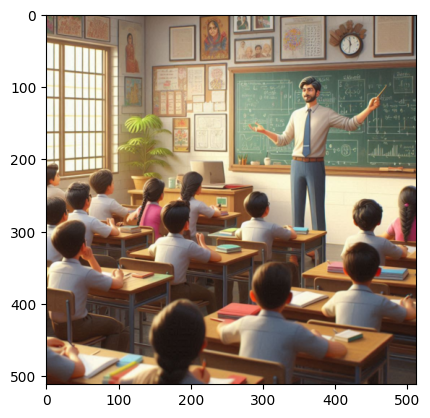

In [5]:
img = load_image("images/Designer.jpeg")
print(img.shape)
display_image(img)

We can see that the size of the image is 512x512. Also, since it is a colored image, we have the components for red, green and blue (thus total size is 512x512x3). Our task here is to do image approximation. For coloured image we will just approximate each channel (R,G,B) and then merge them for approximated image.

We will achieve this by using low rank approximation of the image. 

We will represent the image we have as a matrix(M), or as a collection of vectors.

$$ M = [c_1 \:|\: c_2 \:|\: c_3 \:|\: c_4 ...] \text{ where each } c_i \text{ is a vector in }R^{512} $$
This can be written as
$$ M \: = \: M*I $$
If the columns of $M$ are linearly independent, they form a basis in $R^{512*512}$
Our job is to find a different basis (using PCA, Gram-Schmidt and DFT) such that the matrix will be written as $$ M \: = \: B * C $$

If our basis is of a lesser dimension, we will project each column in $M$ to the subspace created by the basis (columns of the $B$ matrix) which is equivalent to the regression problem of solving for $x_i$ in $ c_i \: - \: Bx_i $ and $Bx_i$ will be our projection (compressed image).

# Principal Component Analysis (PCA)
PCA works by finding a new basis that captures the most significant variations in the data. Here we find top $n\_components$ vectors which captures most variations that occur across our columns $c_i$

More details: https://en.wikipedia.org/wiki/Principal_component_analysis

In [6]:
"""
    Function to compress the image using PCA
"""
def pca_compression(channel, n_components):
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(channel)
    inverted = pca.inverse_transform(transformed)
    return inverted

# Gram-Schmidt Orthogonalization
Gram-Schmidt works by calculating an orthonormal basis for the vectors. We select first n_components columns from the orthonormal basis.

More details: https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process

In [7]:
def gram_schmidt(vectors):
    """
    Performs Gram-Schmidt orthogonalization on a set of vectors.
    
    Args:
        vectors (list): A list of numpy arrays representing the vectors.
        
    Returns:
        numpy.ndarray: An array of orthonormal vectors.
    """
    basis = np.zeros((len(vectors), len(vectors[0])))
    for i, v in enumerate(vectors):
        w = v
        for j in range(i):
            u = basis[j]
            projection = np.dot(w, u) / np.dot(u, u) * u
            w = w - projection
        if np.linalg.norm(w) > 1e-10:
            w = w / np.linalg.norm(w)
            basis[i] = w
    return basis

In [8]:
""" 
    Function to compress the image using Gram-Schmidt Orthogonalization
"""
def gs_compression(channel, n_components):
    basis = gram_schmidt(channel)[:, :n_components]
    coeff = np.dot(basis.T, channel)
    compressed = np.dot(basis, coeff)
    return compressed

# Dicrete Fourier Transform (DFT)
DFT calculates the coefficients corresponding to different frequencies. Here instead of selecting the top frequencies (frequencies which have highest magnitude of coefficient), we just select first n_components columns from the frequency matrix and make the rest 1.

More details: https://en.wikipedia.org/wiki/Discrete_Fourier_transform

In [9]:
""" 
    Function to compress the image using Discrete Fourier Transform
"""
def dft_compression(img, n_components):
    dft_matrix = np.fft.fft2(img)
    mask = np.zeros_like(dft_matrix)
    mask[:, :n_components] = 1
    compressed_matrix = dft_matrix * mask
    compressed_img = np.fft.ifft2(compressed_matrix).real
    return compressed_img

In [10]:
def compress_image(img, n_components, method):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    # r_reshaped = r.reshape(-1, 1)
    # g_reshaped = g.reshape(-1, 1)
    # b_reshaped = b.reshape(-1, 1)
    if method == 'pca':
        r_compressed = pca_compression(r, n_components)
        g_compressed = pca_compression(g, n_components)
        b_compressed = pca_compression(b, n_components)
        img_compressed = np.dstack((r_compressed, g_compressed, b_compressed)).astype(np.uint8)
        return img_compressed
    elif method == 'gs':
        r_compressed = gs_compression(r, n_components)
        g_compressed = gs_compression(g, n_components)
        b_compressed = gs_compression(b, n_components)
        img_compressed = np.dstack((r_compressed, g_compressed, b_compressed)).astype(np.uint8)
        return img_compressed
    elif method == 'dft':
        r_compressed = dft_compression(r, n_components)
        g_compressed = dft_compression(g, n_components)
        b_compressed = dft_compression(b, n_components)
        img_compressed = np.dstack((r_compressed, g_compressed, b_compressed)).astype(np.uint8)
        return img_compressed
    else:
        raise ValueError("Invalid method")

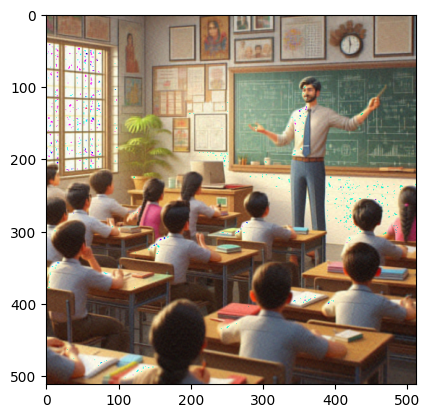

In [11]:
pca_compressed_img = compress_image(img, 100, 'pca')
display_image(pca_compressed_img)

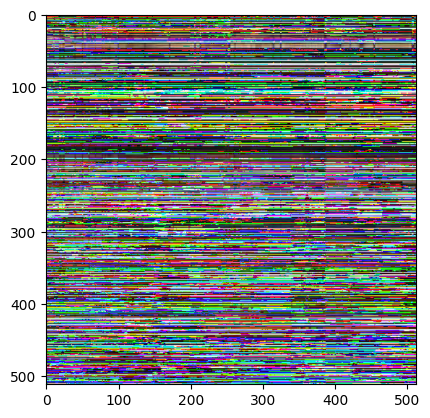

In [12]:
gs_compressed_img = compress_image(img, 50, 'gs')
display_image(gs_compressed_img)

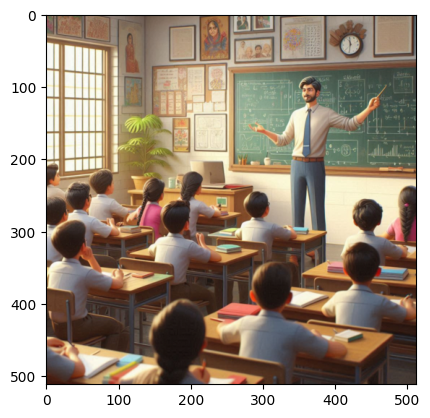

In [13]:
fourier_img = compress_image(img, 512, 'dft')
display_image(fourier_img)

In [14]:
from manim import *
config.media_width = "75%"
config.verbosity = "WARNING"

In [15]:
%%manim -qm CompressionComparison

class CompressionComparison(Scene):
    def construct(self):
        # Calculate the compressed images
        img = load_image("images/Designer.jpeg")
        pca_imgs = []
        gs_imgs = []
        dft_imgs = []
        for x in range(1, 513):
            pca_imgs.append(compress_image(img, x, 'pca'))
            gs_imgs.append(compress_image(img, x, 'gs'))
            dft_imgs.append(compress_image(img, x, 'dft'))
        
        default_img = load_image("images/default.png")

        image = ImageMobject(img)
        text = Text("Let us compare various compression techniques")
        text.scale(0.5)
        image.height = 6
        self.play(Write(text))
        self.wait()
        label = Text("Original Image")
        label.scale(0.5)
        label.next_to(image, DOWN)
        self.play(text.animate.next_to(image, UP))
        self.play(FadeIn(image), Write(label))
        self.wait()
        self.play(image.animate.scale(0.5), FadeOut(label))
        label.next_to(image, DOWN)
        original = Group(image, label)
        
        self.play(original.animate.to_edge(LEFT))
        self.wait()

        pca_compressed_image = ImageMobject(default_img)
        pca_label = Text("PCA")
        pca_label.scale(0.5)
        pca_compressed_image.height = 3
        pca_label.next_to(pca_compressed_image, DOWN)
        pca = Group(pca_compressed_image, pca_label)
        pca.next_to(original, RIGHT)

        gs_compressed_image = ImageMobject(default_img)
        gs_label = Text("Gram-Schmidt")
        gs_label.scale(0.5)
        gs_compressed_image.height = 3
        gs_label.next_to(gs_compressed_image, DOWN)

        gs = Group(gs_compressed_image, gs_label)
        gs.next_to(pca, RIGHT)

        fourier_compressed_image = ImageMobject(default_img)
        fourier_label = Text("DFT")
        fourier_label.scale(0.5)
        fourier_compressed_image.height = 3
        fourier_label.next_to(fourier_compressed_image, DOWN)

        fourier = Group(fourier_compressed_image, fourier_label)
        fourier.next_to(gs, RIGHT)
        
        self.play(FadeIn(pca), FadeIn(gs), FadeIn(fourier))
        sub_dim = Text("Subspace-dimension: ")
        dim = Text(f"512 x {0}")
        sub_dim.scale(0.5)
        dim.scale(0.5)
        dim.next_to(sub_dim, RIGHT)

        dim_text = VGroup(sub_dim, dim)
        dim_text.next_to(gs, DOWN, buff=0.5)
        dim_text.shift(LEFT)
        self.play(Write(dim_text))
        self.wait()
        for x in range(len(pca_imgs)):
            pca_img = ImageMobject(pca_imgs[x])
            pca_img.height = 3
            pca_img.move_to(pca_compressed_image.get_center())
            gs_img = ImageMobject(gs_imgs[x])
            gs_img.height = 3
            gs_img.move_to(gs_compressed_image.get_center())
            fourier_img = ImageMobject(dft_imgs[x])
            fourier_img.height = 3
            fourier_img.move_to(fourier_compressed_image.get_center())
            new_dim = Text(f"512 x {x+1}")
            new_dim.scale(0.5)
            new_dim.move_to(dim.get_center())
            self.play(Transform(pca_compressed_image, pca_img), Transform(gs_compressed_image, gs_img), Transform(fourier_compressed_image, fourier_img) ,Transform(dim, new_dim))

        self.wait()

Manim Community v0.18.1